# Install required packages


# Install requirements

In [1]:
import sys
!{sys.executable} -m pip install pandas
!{sys.executable} -m pip install matplotlib
!{sys.executable} -m pip install sklearn
!{sys.executable} -m pip install requests

# Run setup

In [2]:
"""
To run this notebook in Google Colab, you need to the following first:
1. Open this link: https://drive.google.com/drive/folders/1adprVKMxSlXTn-S3ZAbOx545cxv5CzHl?usp=sharing
2. Then go to "Shared with me" in your Google Drive, right-click the "AIUK" folder
and select "Add shortcut to Drive"

Optionally, if you don't have a Google Drive account, you can set colab to False,
and download the data.
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as dates
from pathlib import Path

%matplotlib inline
%config InlineBackend.figure_format='retina'

plt.style.use('seaborn')
plt.rcParams["figure.figsize"] = (15,10)

colab = False

if colab:
    from google.colab import drive
    drive.flush_and_unmount()
    drive.mount('/content/drive')
    root_dir = Path('/content/drive/MyDrive/AIUK')
else:
    from data import download_data
    download_data()
    root_dir = Path('./')

# Climate change indicators dataset

Anthropogenic climate change is one of the most important social issues facing humanity, and one in which big data can play a role in determining the most effective policy interventions. Today, we'll be taking a look at some of the key indicators of warming, including CO2 levels, glacier size, change in sea levels, and so on. We will also be making data available on some human factors involved, including impacts of fossil fuel burning per nation, and the fluctuating price of carbon credits.

Dataset source: https://datahub.io/collections/climate-change

In the next few cells we'll explore the datasets. Let's first take a look at the dataset which gives us the average monthly concentration of CO2 at the Mauna Loa observatory, measured in parts per million (PPM).



In [3]:
co2_df = pd.read_csv(root_dir.joinpath('co2_monthly.csv'), parse_dates=['Date'])
co2_df.head()

,Date,Decimal Date,Average,Interpolated,Trend,Number of Days
0,1958-03-01,1958.208,315.71,315.71,314.62,-1
1,1958-04-01,1958.292,317.45,317.45,315.29,-1
2,1958-05-01,1958.375,317.50,317.50,314.71,-1
3,1958-06-01,1958.458,-99.99,317.10,314.85,-1
4,1958-07-01,1958.542,315.86,315.86,314.98,-1


As you can see, we get the date in YYYY-MM-DD format, with a monthly average, as well as a seasonally-corrected trend. Number of days refers to the number of day readings averaged, -1 denoting that the monthly data is interpolated from other sources.

Let's plot the monthly average since 1990, and generate a best fit line showing the trend.

In [4]:
since_90 = co2_df[co2_df.Date>'1990']
date_num = dates.date2num(since_90.Date)
params = np.polyfit(date_num, since_90.Average, 1)
fit = np.poly1d(params)
x_fit = np.linspace(date_num.min(), date_num.max())

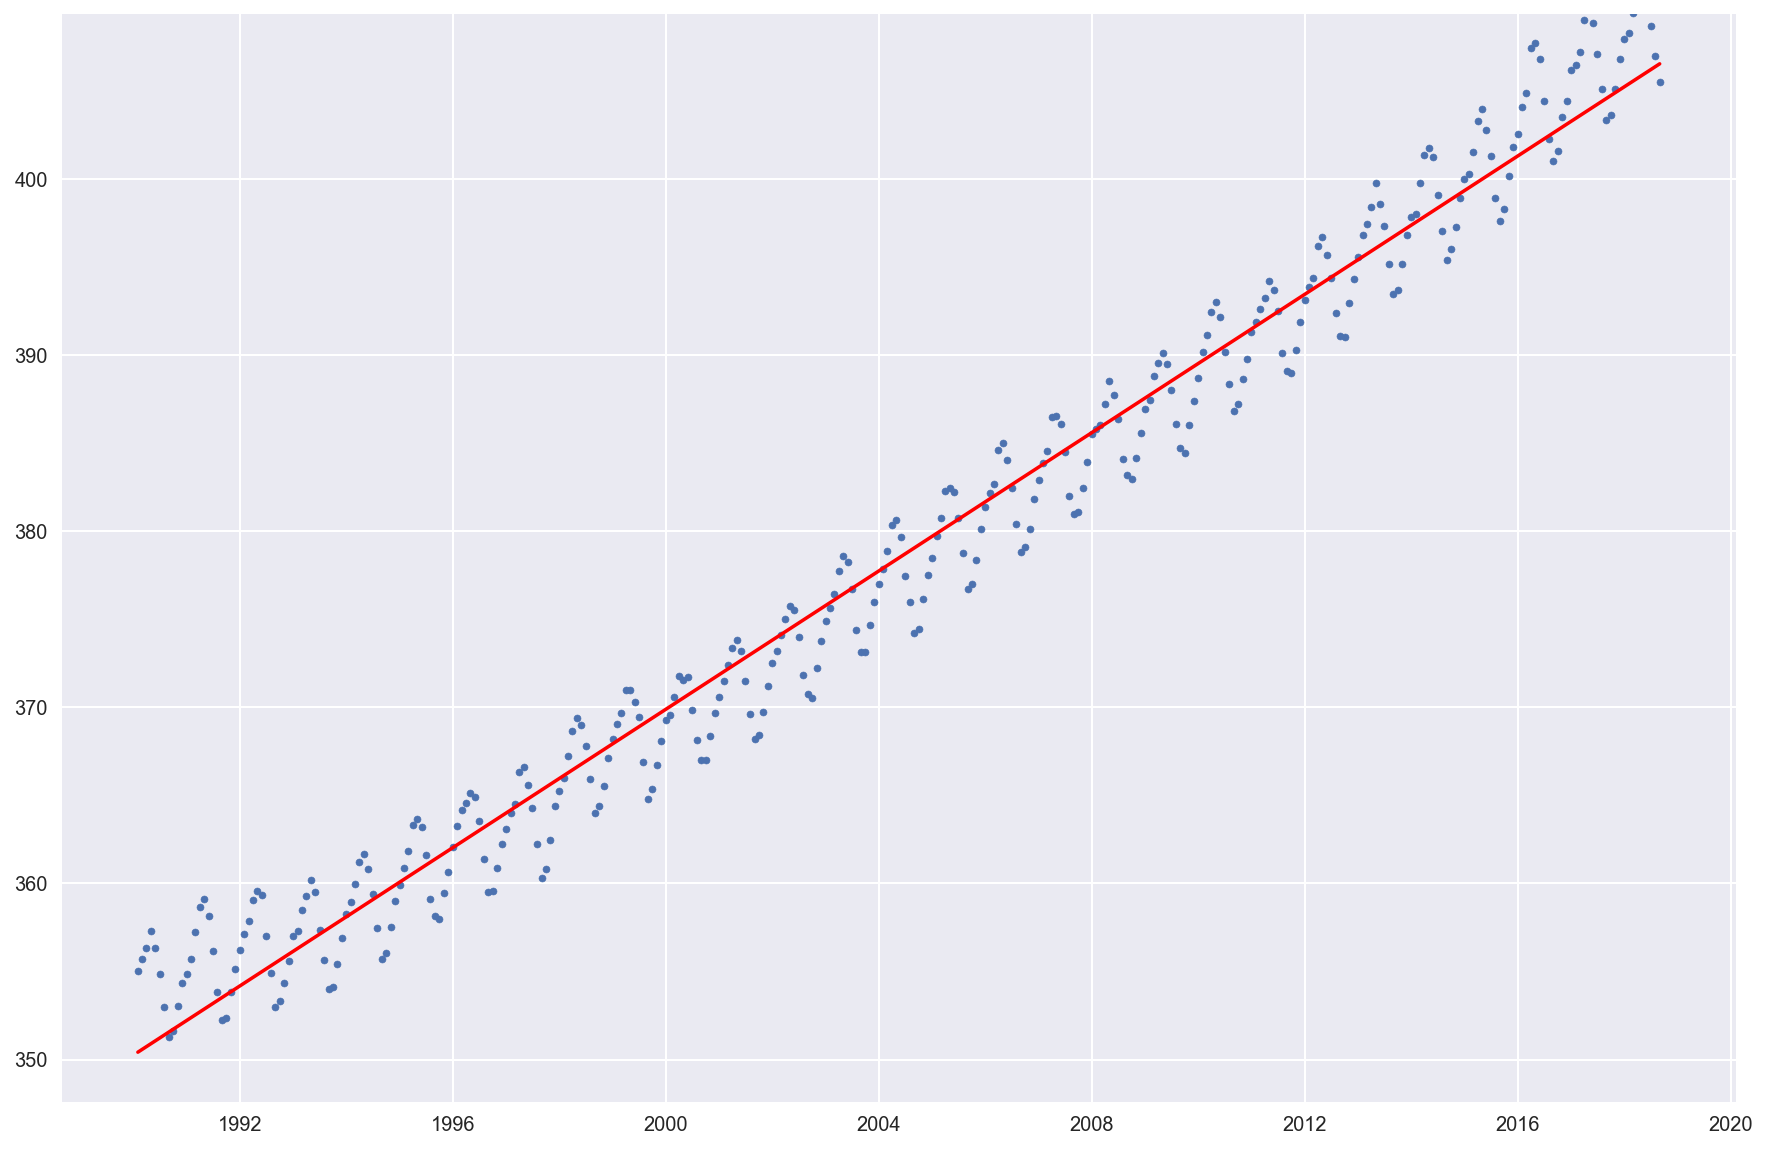

In [5]:
fig, ax = plt.subplots()
ax.scatter(pd.to_datetime(since_90.Date), since_90.Average, marker='.')
ax.plot(dates.num2date(x_fit), fit(x_fit), 'r')
plt.show()

What about the correlation between temperature change and CO2? Let's add our global anomalous temperatures dataset to our plot as well.

In [6]:
temp_df = pd.read_csv(root_dir.joinpath('temp_monthly.csv'), parse_dates=['Date'])
temp_df.head()

,Source,Date,Mean
0,GCAG,2016-12-06,0.7895
1,GISTEMP,2016-12-06,0.8100
2,GCAG,2016-11-06,0.7504
3,GISTEMP,2016-11-06,0.9300
4,GCAG,2016-10-06,0.7292


In [7]:
temp_since_90 = temp_df.loc[(temp_df.Date > '1990') & (temp_df.Source == 'GISTEMP')]

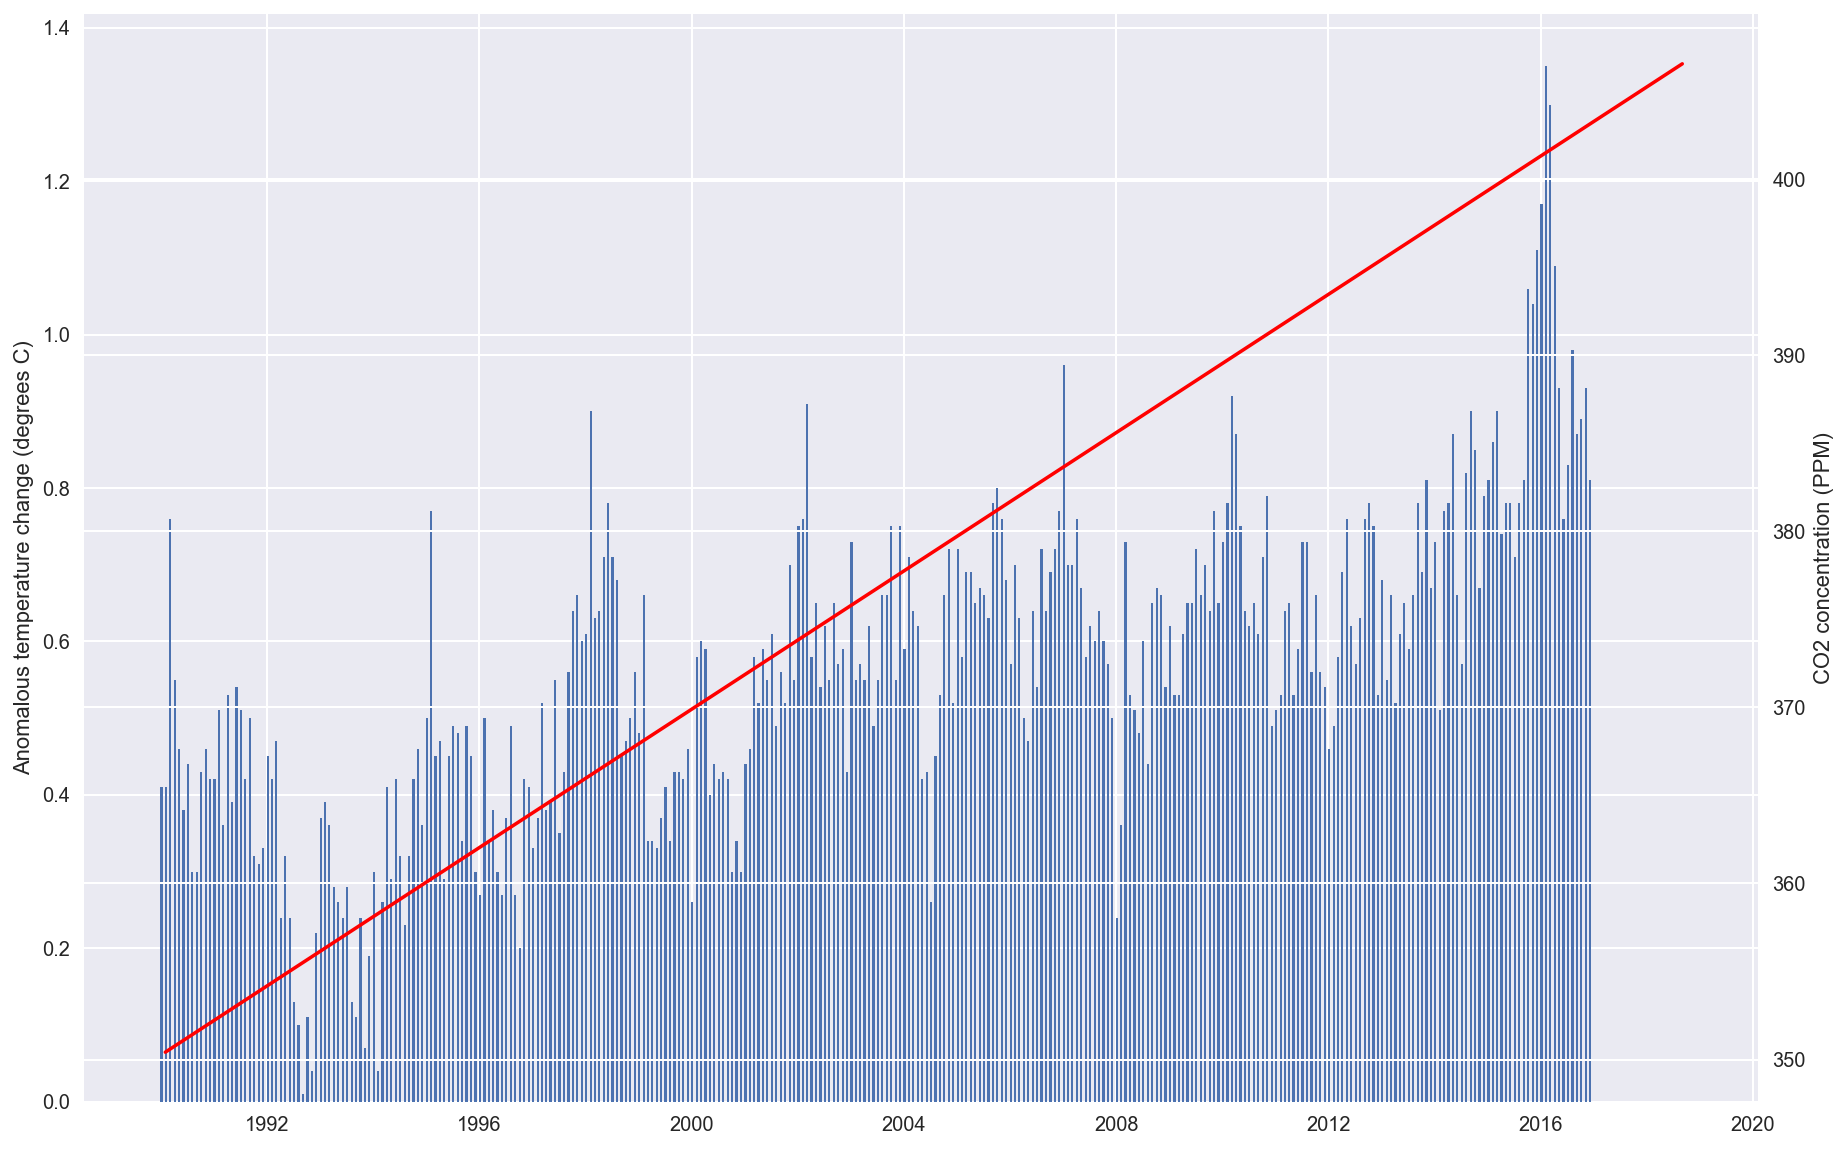

In [8]:
fig, ax = plt.subplots()
ax.bar(pd.to_datetime(temp_since_90.Date), temp_since_90.Mean, width=15.0)
ax.set_ylabel('Anomalous temperature change (degrees C)')

ax2 = ax.twinx()
ax2.set_ylabel('CO2 concentration (PPM)')

ax2.plot(dates.num2date(x_fit), fit(x_fit), 'r')
plt.show()

For millions of people around the world, the most immediate impact of climate change is sea level rise, which threatens not only homes and businesses, but also vast areas of agricultural land, as well as access to clean, desalinated water.

<img src="https://cloudfront-us-east-2.images.arcpublishing.com/reuters/3XK6LJVMXBMXZMBV45JCDUZN6Y.jpg">


Let's take a look at the sea level dataset.


In [9]:
s_df = pd.read_csv(root_dir.joinpath('sea_level.csv'), parse_dates=['Year'])
s_df.head()

,Year,CSIRO Adjusted Sea Level,Lower Error Bound,Upper Error Bound,NOAA Adjusted Sea Level
0,1880-03-15,0.000000,-0.952756,0.952756,NaN
1,1881-03-15,0.220472,-0.732283,1.173228,NaN
2,1882-03-15,-0.440945,-1.346457,0.464567,NaN
3,1883-03-15,-0.232283,-1.129921,0.665354,NaN
4,1884-03-15,0.590551,-0.283465,1.464567,NaN


This set provides two measurements of changes in the average sea level in inches per year since 1880, provided by the CSIRO (Commonwealth Scientific and Industrial Research Organization) and EPA (United States Environmental Protection Agency). We can see where these measurements overlap by plotting the trend of each since 1990.

In [10]:
s_since_90 = s_df[s_df.Year > '1990']

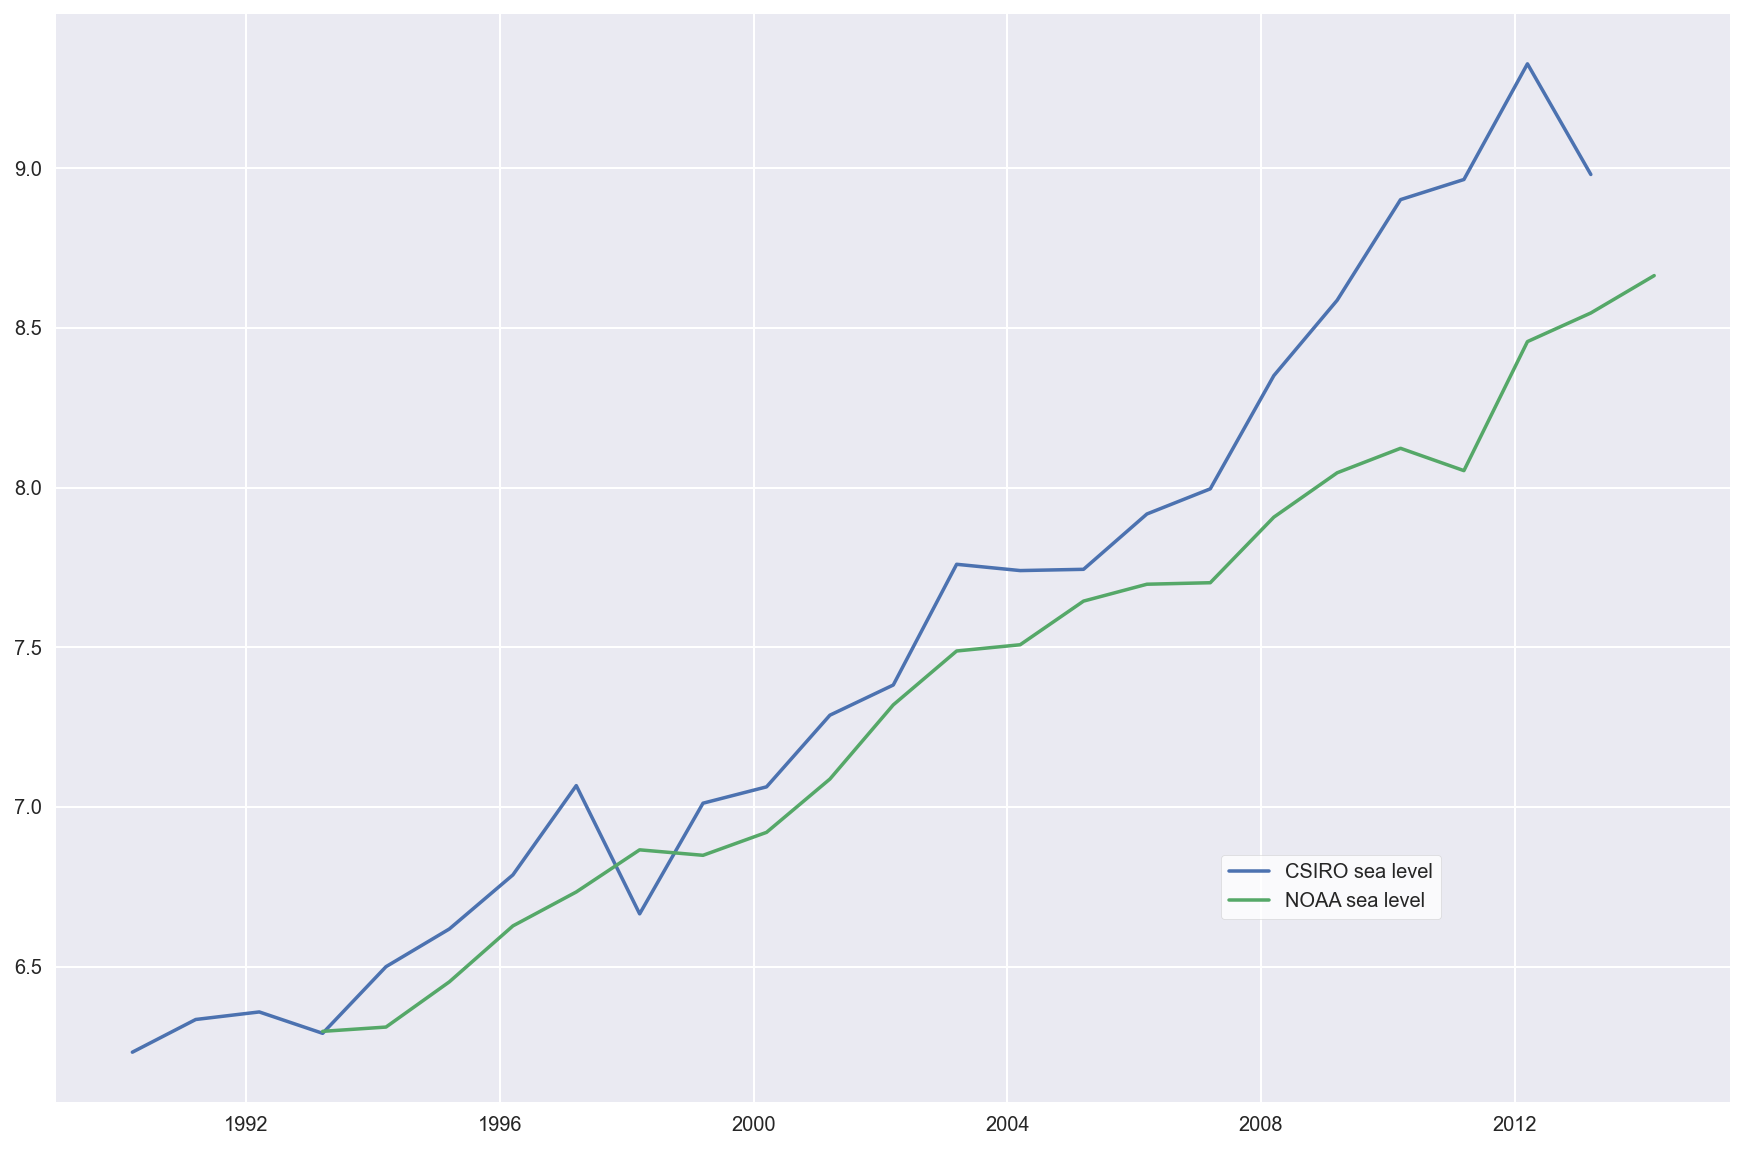

In [11]:
fig, ax = plt.subplots()
ax.plot(pd.to_datetime(s_since_90.Year), s_since_90['CSIRO Adjusted Sea Level'], label='CSIRO sea level')
ax.plot(pd.to_datetime(s_since_90.Year), s_since_90['NOAA Adjusted Sea Level'], label='NOAA sea level')
fig.legend(loc=(0.7, 0.2), frameon=True, facecolor='white')
plt.show()

The rate of increase is somewhat linear, with ~9 inches higher average sea levels over the 1880 figure, but lets try to predict what the increase might look like over the next 30 years. To do that, we'll train a simple regression model.

We'll first collect our data and resample our time scale to the year.

In [12]:
s = s_df[['Year', 'CSIRO Adjusted Sea Level']].groupby(pd.Grouper(key='Year', axis=0, freq='Y')).mean().reset_index()
s.rename(columns = {'Year':'Date', 'CSIRO Adjusted Sea Level': 'Sea Level'}, inplace = True)
s = s[s.Date < '2014']
s.head()

,Date,Sea Level
0,1880-12-31,0.000000
1,1881-12-31,0.220472
2,1882-12-31,-0.440945
3,1883-12-31,-0.232283
4,1884-12-31,0.590551


Then, we'll train a linear regressor to predict our outcome (Sea Level) from the date. First, we'll split our available data into a training and test set, then train our regression with the labels from the training set. Then, we'll make some predictions on the test set, and see how well our model fits.

**NOTE**: this is obviously not a practical solution, given that the rate of sea level rises probably isn't solely determined by the calendar year, but multiple climate-related factors, but it will work as a simple demonstration of the principle.

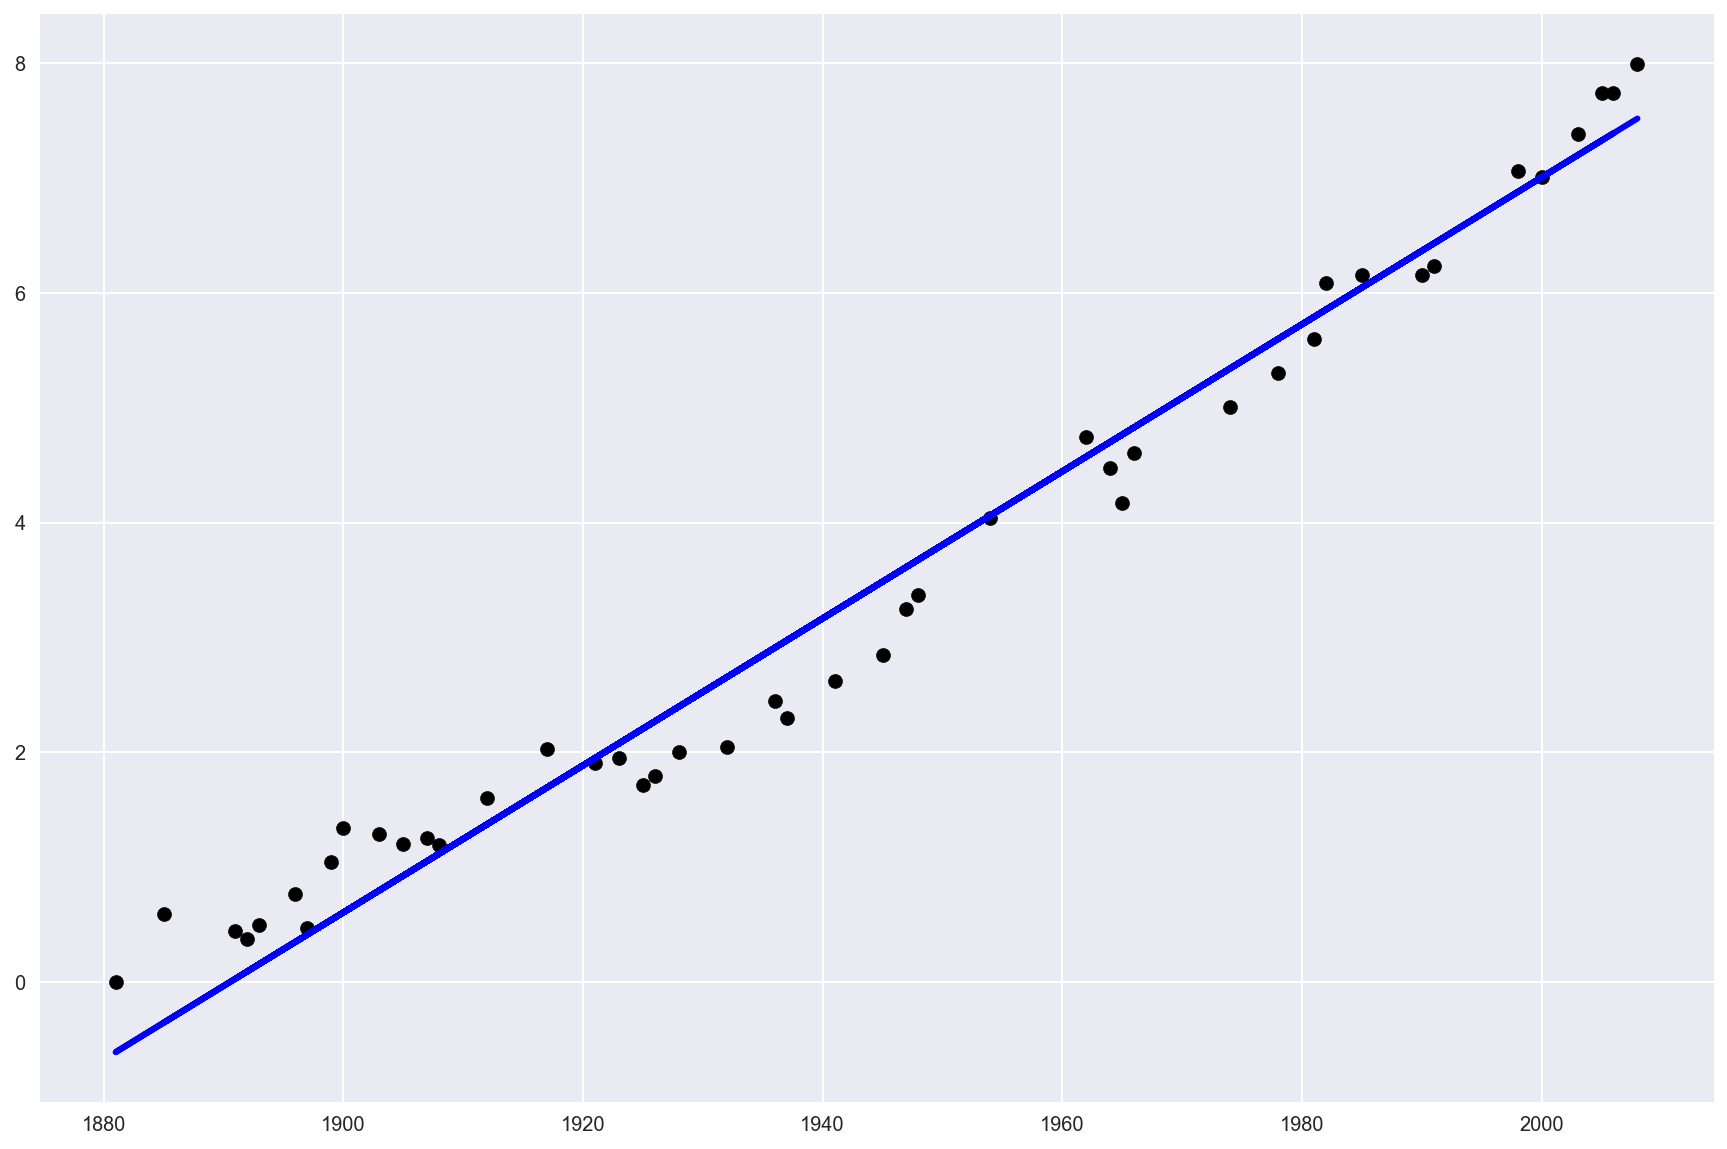

In [13]:
from sklearn import linear_model, model_selection
import datetime

X = np.array(s['Date'].apply(lambda x:x.toordinal())).reshape(-1, 1)
y = s['Sea Level']

X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.33, random_state=42)
regressor = linear_model.LinearRegression()
regressor.fit(X_train, y_train)

y_pred = regressor.predict(X_test)

x_dt = [datetime.date.fromordinal(x[0]) for x in X_test]

plt.scatter(x_dt, y_test, color="black")
plt.plot(x_dt, y_pred, color="blue", linewidth=3)

plt.show()

The regression seems to fit quite well with the data that we've got so far, so let's make some predictions for the future.

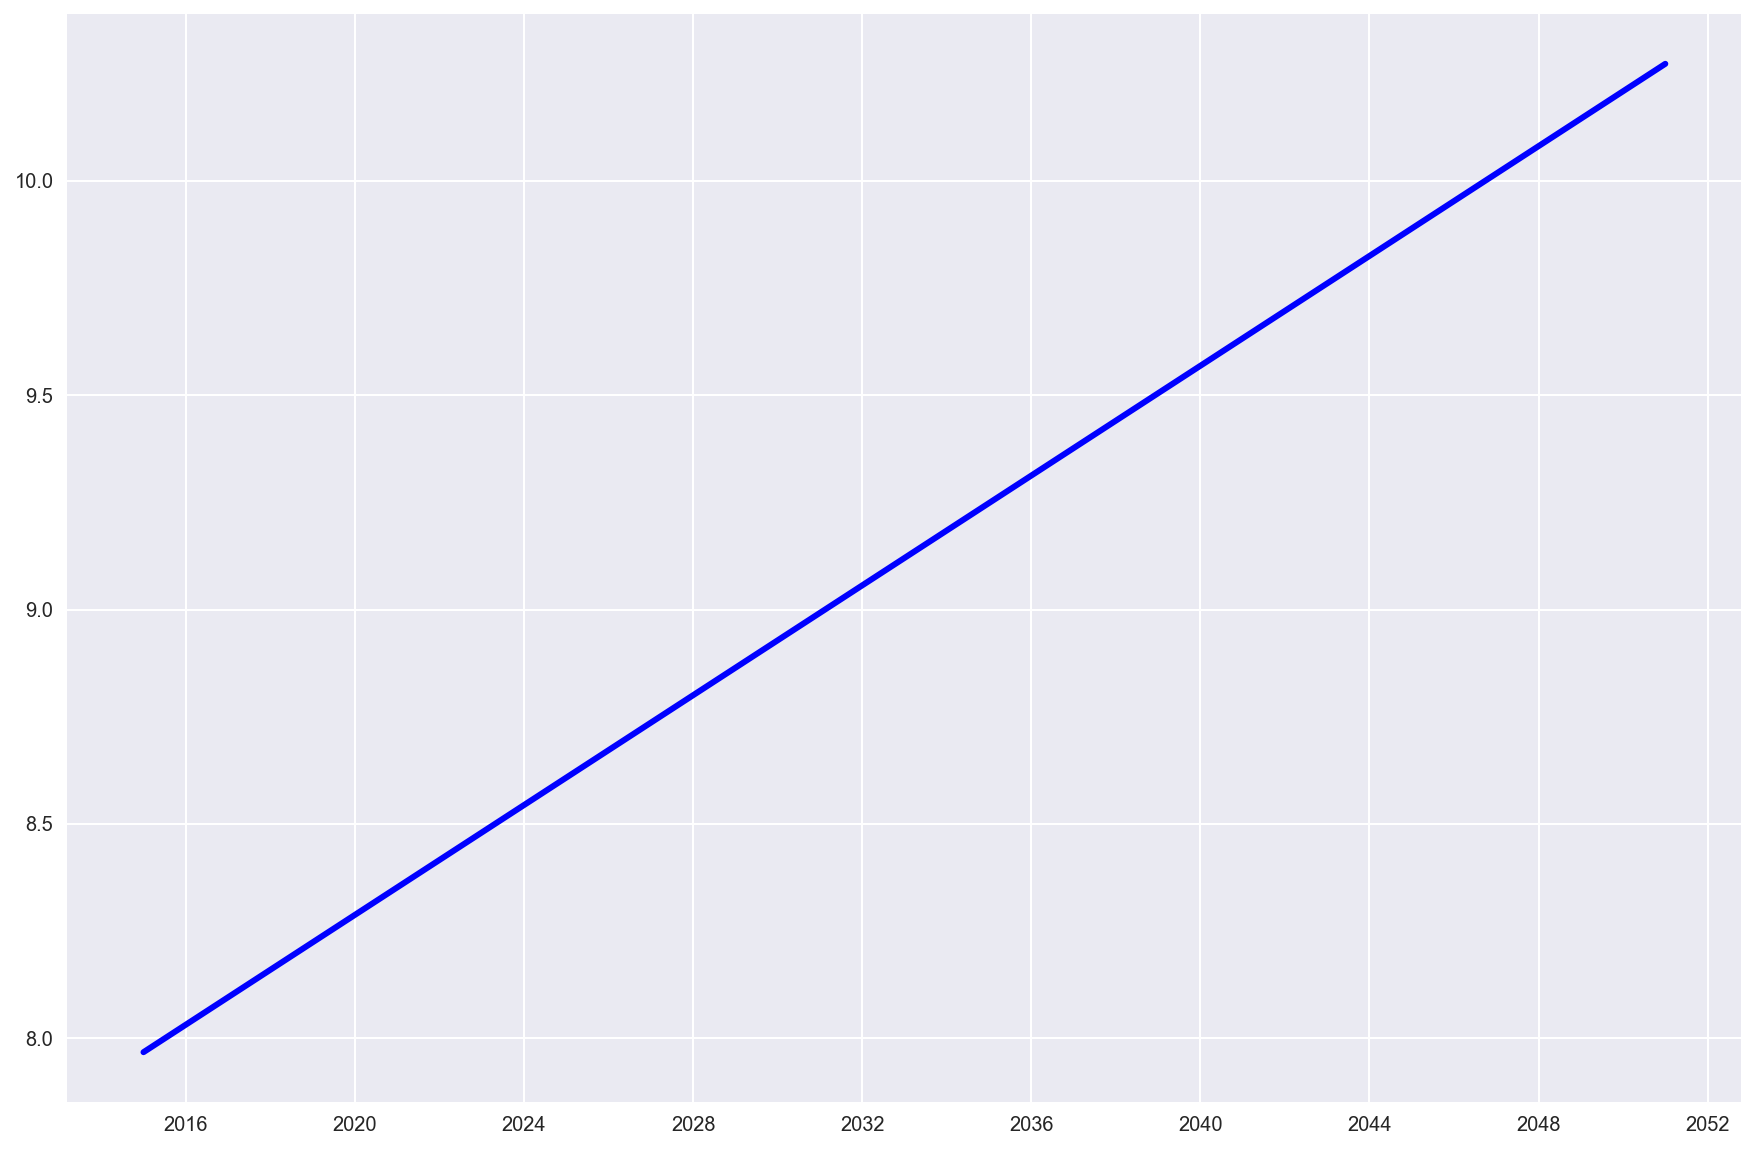

In [14]:
start = '2014-12-31'
end = '2050-12-31'

new_dates = pd.date_range(start, end, freq='1Y')
x_fut = np.array(new_dates.to_series().apply(lambda x:x.toordinal())).reshape(-1, 1)

y_pred = regressor.predict(x_fut)
fut_dt = [datetime.date.fromordinal(x[0]) for x in x_fut]

plt.plot(fut_dt, y_pred, color="blue", linewidth=3)

plt.show()

From this simple prediction, we can see that if the rate of increase stays stable, we can expect greater than 10 inches of sea level rise by 2050: [enough to put large parts of England, as well as virtually the entire Netherlands](https://coastal.climatecentral.org/map/8/1.1818/51.4022/?theme=sea_level_rise&map_type=year&basemap=roadmap&contiguous=true&elevation_model=best_available&forecast_year=2050&pathway=rcp45&percentile=p50&refresh=true&return_level=return_level_1&rl_model=gtsr&slr_model=kopp_2014), under water.

![London flooding](https://2.bp.blogspot.com/_Fv90J7eTcis/TFs8VbyP1fI/AAAAAAAAGKc/tF6rECNfLbE/s1600/Flood.jpg)

# Climate change sentiment dataset

Beyond the bare numbers, combating climate change will require buy-in from people in all walks of life. Part of persuading people about the need to combat the deadly outcomes of global warming is identifying which parts of the population are already persuaded, and what evidence each side is deploying to support their point of view.

We've provided a dataset includes a large group of social media posts related to climate change, annotated by human experts as referring to either factual news sources (2), or as opinion indicating that the person is promoting either belief or disbelief in anthropogenic warming (1 or -1). Messages without an obvious valence are marked with a 0.

You can find that dataset in your Google Drive at /content/drive/MyDrive/AIUK/cc_sentiment.csv

Dataset source: https://www.kaggle.com/edqian/twitter-climate-change-sentiment-dataset

TODO: show class balance

TODO: BOW predictions

# Ideas for discussion

*  look at what countries have historically emitted a lot of co2, and what has changed over time?
*  extrapolate from the cc data to see what potential changes could do to temperature/atmospheric co2?
*  what is the impact of carbon credit trading? can we see any links with national co2 emissions?
*  what topics people who believe in human-caused climate change talk about, versus those who don't?
*  do believers/non-believers form networks - do they retweet each other a lot?
*  can you predict from a message text whether a person is going to believe in anthropogenic climate change or not? 
*  what about if you disregard named entities, like the UN, IPCC, and so on?

# Presenting your work


*  what we want: an interesting finding for discussion and a single slide
*  5 minute slot for showing what you've got + questions
*  add link to slide template

